In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5py
from glob import glob
import os
import rasterio
import osgeo
from osgeo import gdal
from rasterio.transform import from_origin
import rasterio
from rasterio.plot import show 
from matplotlib import colors
import site
import sys
import tarfile
import gzip
from scipy.interpolate import griddata
from scipy.spatial import KDTree


## Make sure all packages are loaded

In [4]:
# Get the user site-packages directory
user_site_packages = site.getusersitepackages()

# Add it to sys.path if it's not already there
if user_site_packages not in sys.path:
    sys.path.append(user_site_packages)

# Now import the package installed with --user
import natsort  # Replace with the package you want to import
import dbfread

In [5]:
output = '/home/adelaly/BA_work/output/Cartagena_2019/'
begin_long = -2.5
end_long = 0.5
begin_lat = 36.5
end_lat = 39.5
begin_date = '2019-09-11 07:00:00'
end_date = '2019-09-13 06:00:00'

### Take the positions of AEMET precipitations sations and plot a topographic map

In [17]:
from dbfread import DBF
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:25830", "epsg:4326", always_xy=True)

In [18]:
cord = []
lon = []
lat = []

for rec in  DBF('/home/adelaly/BA_work/raw_data/Cartagena_2019/stations_AEMET/Estaciones_Pluviometricas.dbf'):
    x = rec['COORD_X']
    y = rec['COORD_Y']
    cord.append( transformer.transform(x,y))
    
table = DBF('/home/adelaly/BA_work/raw_data/Cartagena_2019/stations_AEMET/Estaciones_Pluviometricas.dbf', load = True)


for pos in cord :
    lon.append(pos[0])
    lat.append(pos[1])

grid_st = pd.DataFrame({
    'longitude': lon,
    'latitude' : lat
})



In [23]:
from topography import topo_map

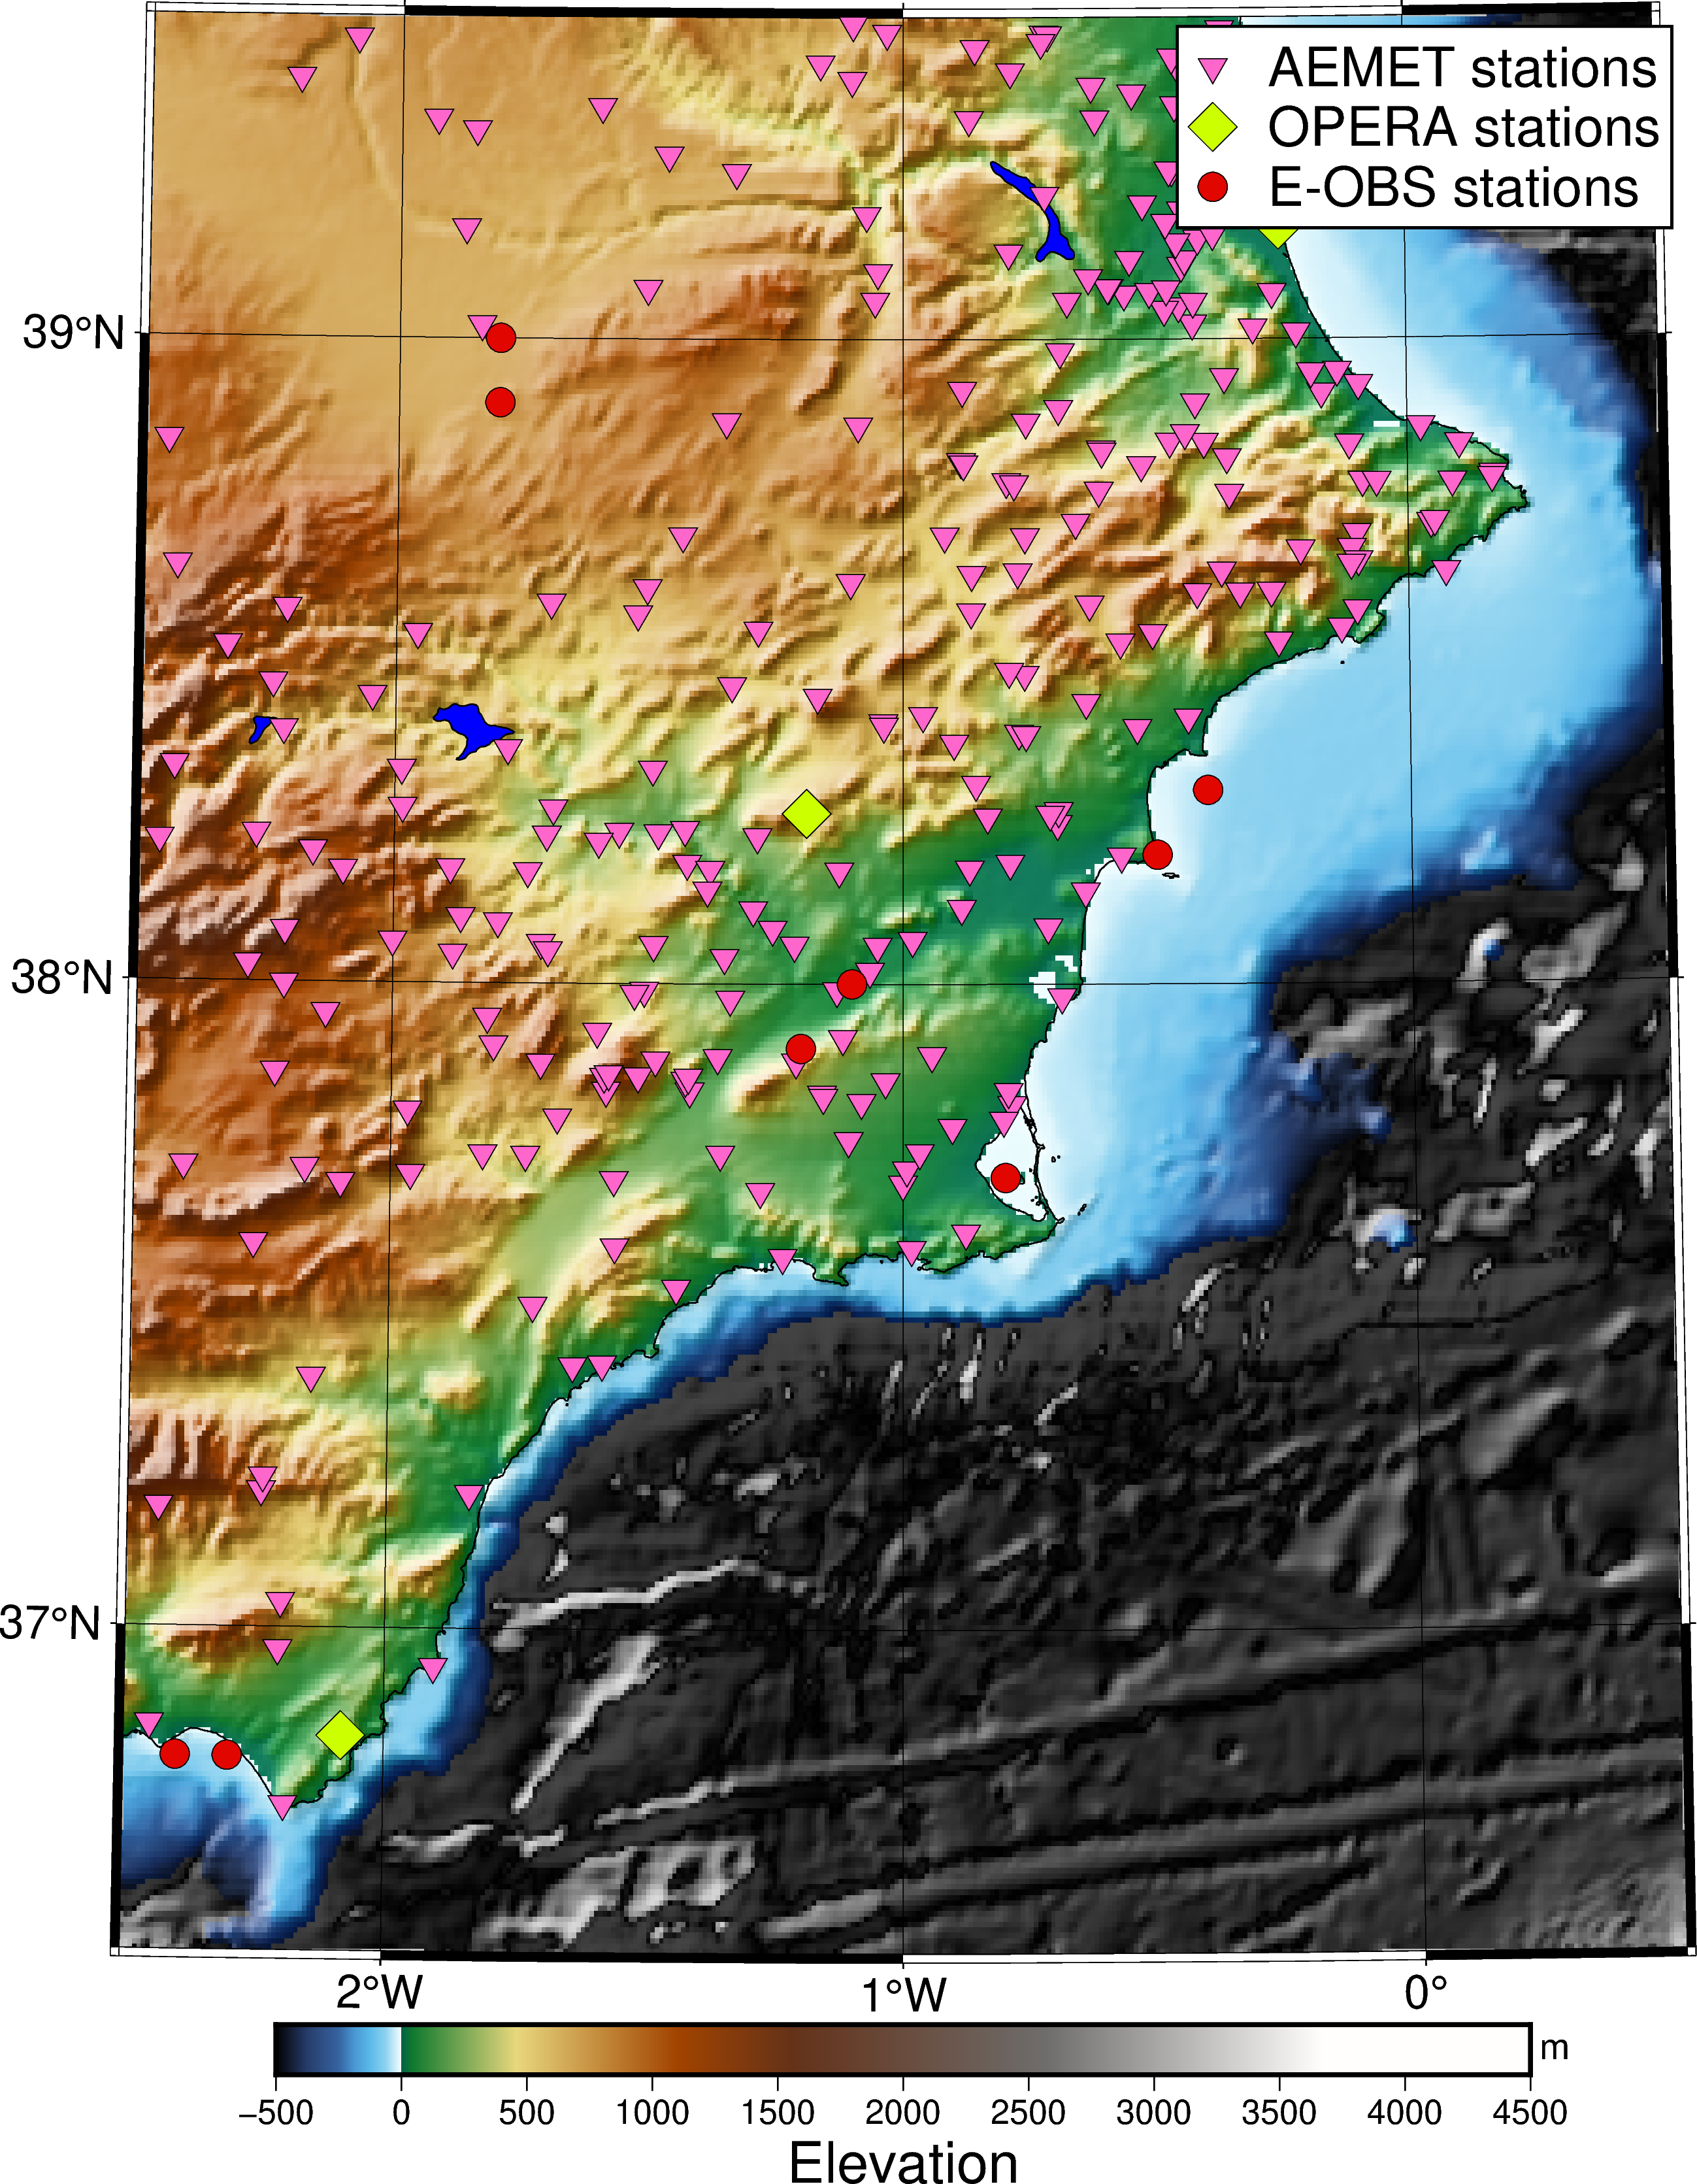

In [24]:
topo_map(
    begin_long = begin_long,
    end_long = end_long,
    begin_lat = begin_lat,
    end_lat = end_lat,
    begin_date = begin_date,
    end_date = end_date,
    grid_st = grid_st,
    name = 'Crtg',
    other = 'AEMET',
    output = output,
    plot = True,
    save = True,
    plot_eobs = True,
    plot_opera = True
)

## Extract data for 11.09.2019 06:00 until 13.09.2019 06:00

In [4]:
from EURADCLIM_acc_orig import accumulation as EU_orig #take all the files from a path,accumulate the rain, make a csv file of it and make a projection
from  MSWEP_acc_orig import accumulation as MS_orig
from ERA5_acc_orig import accumulation as ER_orig
from IMERG_acc_orig import accumulation as IM_orig
from EOBS_acc_orig import accumulation as EO_orig


In [13]:
EO_orig(
    file_path = '/home/adelaly/BA_work/raw_data/E_OBS_rr_ens_mean_0.1deg_reg_2011-2024_v30.0e.nc',
    begin_date = '2019-09-12',
    end_date = '2019-09-13',
   begin_long = begin_long,
    end_long = end_long,
    begin_lat = begin_lat,
    end_lat = end_lat,
    name = 'EOBS_Cartagena_2019_orig',
    output = output
)

In [ ]:
# But I dont run it

EU_orig(
    output = output,
    file_path = '/home/adelaly/BA_work/raw_data/Cartagena_2019/RAD_OPERA',
    end_date = "20190913",
    end_time = "060000",
    name = 'EURADCLIM_Cartagena_2019_orig',
    begin_long = begin_long,
    end_long = end_long,
    begin_lat = begin_lat,
    end_lat = end_lat,
    output_accumulation = 'Accumulated_precip_Cartagena.h5'
)

In [15]:
MS_orig(
    input_dir = '/home/adelaly/BA_work/raw_data/Cartagena_2019/MSWEP',
    output = output,
    begin_long = begin_long,
    end_long = end_long,
    begin_lat = begin_lat,
    end_lat = end_lat,
    name = 'MSWEP_Cartagena_2019_orig'
)

In [16]:
ER_orig(
    file_path = '/home/adelaly/BA_work/raw_data/Cartagena_2019/c3254f0a6d81b1df95f4669b3b66b185.grib',
    begin_date = '2019-09-11 07:00:00',
    end_date = '2019-09-13 06:00:00',
    begin_long = begin_long,
    end_long = end_long,
    begin_lat = begin_lat,
    end_lat = end_lat,
    name = 'ERA5_Cartagena_2019_orig',
    output = output
)

In [17]:
# in the IMERG folder all file from 06:30 until the end

IM_orig(
    file_path = '/home/adelaly/BA_work/raw_data/Cartagena_2019/IMERG',
    begin_long = begin_long,
    end_long = end_long,
    begin_lat = begin_lat,
    end_lat = end_lat,
    name = 'IMERG_Cartagena_2019_orig',
    output = output
)

## Adjust EURADCLIM

In [18]:
from EURADCLIM_acc_orig_adjusted import accumulation as EU_orig_adjusted

In [19]:
# Add some threshold to delete some spurioous data echoes (obviously bigger than 50mm/h) and to not have too much 0 values
EU_orig_adjusted(
    output = output,
    file_path = '/home/adelaly/BA_work/raw_data/Cartagena_2019/RAD_OPERA',
    end_date = "20190913",
    end_time = "060000",
    name = 'EURADCLIM_Cartagena_2019_orig_adjusted',
    begin_long = begin_long,
    end_long = end_long,
    begin_lat = begin_lat,
    end_lat = end_lat,
    output_accumulation = 'Accumulated_precip_Cartagena.h5',
    threshold = 90,
    final_threshold = 900
)



/home/adelaly/BA_work/main/EURADCLIM_acc_orig_adjusted.py:165: RuntimeWarning: invalid value encountered in divide
  grid_vals = np.where(norm_weights > 0, weighted_vals/norm_weights, np.nan)


## AEMET extract

In [37]:
tar_gz_path = '/home/adelaly/BA_work/raw_data/Cartagena_2019/Serie_AEMET_v2_pcp_1951a2022_txt.tar.gz'

with tarfile.open(tar_gz_path, 'r:gz') as tar:
    tar.extractall()  

In [41]:
with gzip.open('/home/adelaly/BA_work/main/pcp_red_SPAIN_1951-20221231.txt.gz', 'rb') as gz_file:
    with open('/home/adelaly/BA_work/main/pcp_red_SPAIN_1951-20221231.txt', 'wb') as txt_file:
        txt_file.write(gz_file.read())


### Make a grid with the maestro

In [43]:
grid_point = pd.read_csv(
    'maestro_red_hr_SPAIN.txt',
    sep='\s+',      # Split on whitespace
    names=['grid_id', 'longitude', 'latitude', 'height'],
    header=None
)

### Make a datframe with all data from a time

In [45]:
date_start = 20190911
date_end = 20190913
grid_ids = grid_point['grid_id'].tolist()
with open('/home/adelaly/BA_work/test/pcp_red_SPAIN_1951-20221231.txt', 'r') as f:
    lines = f.readlines()

# Parse data
dates = []
precip_data = []
for line in lines:
    date = int(line[:10])  

    if date_start <= date <= date_end:
        dates.append(date)
        values = list(map(float, line[8:].split()))
        precip_data.append([values[i-1] for i in grid_ids])  

# Create DataFrame
df = pd.DataFrame(
    precip_data,
    index=pd.to_datetime(dates, format='%Y%m%d'),
    columns=grid_ids
)

In [46]:
ds = df.sum()
precip_df = pd.DataFrame({
    'grid_id': range(1, 16157),  
    'precipitation': ds  # Your summed values
})


In [48]:
final_df = pd.merge(
    precip_df,
    grid_point[['grid_id', 'longitude', 'latitude']],
    on='grid_id',
    how='left'  # Ensure all grid_ids are preserved
)

final_df.to_csv(output + 'AEMET_orig.csv')

In [56]:
source = output + 'AEMET_orig.csv'
source = pd.read_csv(source)
x_col = 'longitude'
y_col = 'latitude'
value_col = 'precipitation'
res = 0.05

xmin = source[x_col].min() - res
xmax = source[x_col].max() + res
ymin = source[y_col].min() - res
ymax = source[y_col].max() + res

grid_lons = np.arange(xmin + res/2, xmax, res)
grid_lats = np.arange(ymin + res/2, ymax, res)



# 3. Spatial interpolation with bounds checking
tree = KDTree(source[[x_col, y_col]].values)

# Find nearest 4 points within 1.5x the source resolution
max_dist = max(res, res) * 1.5
query_points = np.array(np.meshgrid(grid_lons, grid_lats)).T.reshape(-1,2)
dists, idxs = tree.query(query_points, k=min(4, len(source)), distance_upper_bound=max_dist)

# Handle cases where no neighbors are found
valid_mask = (idxs < len(source)).all(axis=1)
weights = np.where(dists > 0, 1/(dists**2 + 1e-9), 1)
weights[~valid_mask] = 0

# Safe indexing
source_values = source[value_col].values
weighted_vals = np.zeros(len(query_points))
for i in range(weights.shape[1]):
    valid_idx = idxs[:,i] < len(source_values)
    weighted_vals[valid_idx] += weights[valid_idx,i] * source_values[idxs[valid_idx,i]]

norm_weights = np.sum(weights, axis=1)
grid_vals = np.where(norm_weights > 0, weighted_vals/norm_weights, np.nan)

# 4. Create filled output DataFrame
grid_df = pd.DataFrame({
    y_col: np.tile(grid_lats, len(grid_lons)),
    x_col: np.repeat(grid_lons, len(grid_lats)),
    value_col: grid_vals
})

grid_df = grid_df.fillna(0)
grid_df = grid_df[
    (grid_df['latitude'].between(begin_lat, end_lat)) & 
    (grid_df['longitude'].between(begin_long, end_long))

]



# 4. Save to CSV
grid_df.to_csv(output + 'AEMET_orig_adjusted.csv', index=False)

/tmp/ipykernel_41771/584668035.py:39: RuntimeWarning: invalid value encountered in divide
  grid_vals = np.where(norm_weights > 0, weighted_vals/norm_weights, np.nan)


## Visualize the original

In [24]:

from projection import multiple_plots

In [23]:
A = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EOBS_orig.csv')
B = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/ERA5_orig.csv')
C = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EURADCLIM_orig_adjusted.csv')
D = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/IMERG_orig.csv')
E = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/MSWEP_orig.csv')
F = pd.read_csv('/home/adelaly/BA_work/test/AEMET_orig_adjusted.csv')
G = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/AEMET_orig_adjusted.csv')

In [25]:
A.name = 'EOBS'
B.name = 'ERA5'
C.name = 'EURADCLIM'
D.name = 'IMERG'
E.name = 'MSWEP'
F.name = 'AEMET'
G.name = 'AEMET'
data = [A,B,C,D,E,G]


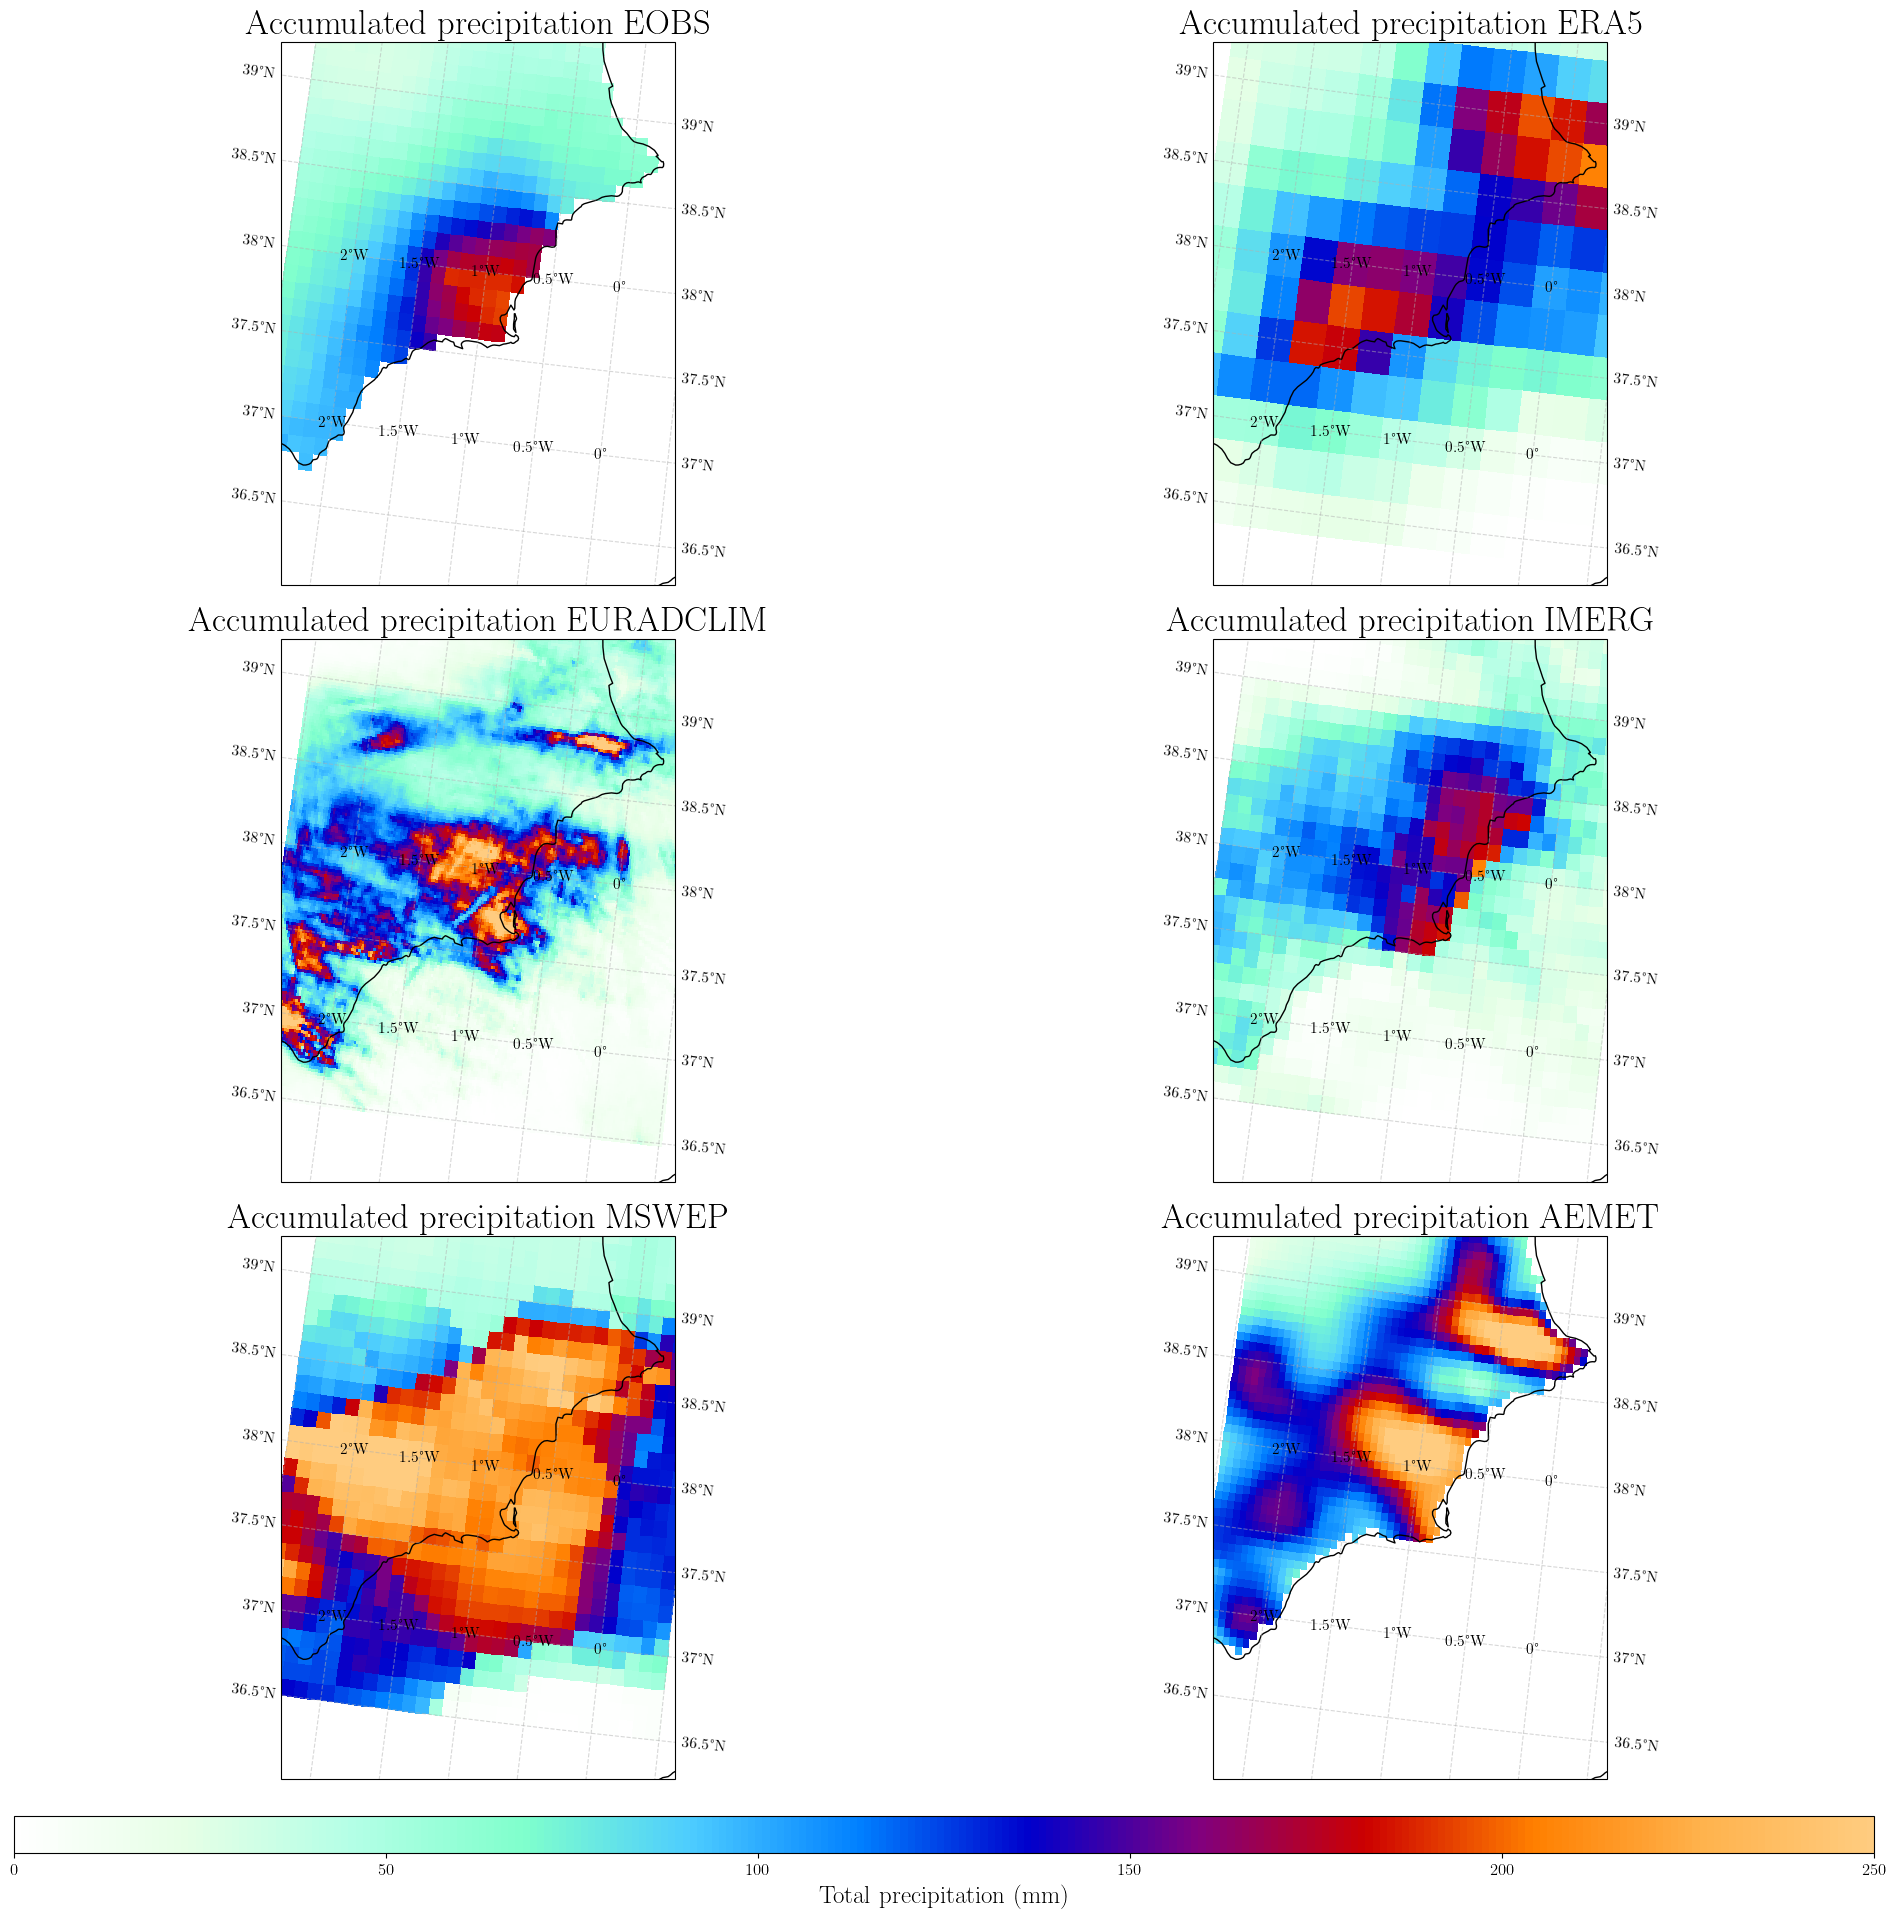

In [26]:
multiple_plots(
    datasets = data,
    name = 'Accumulated precipitation',
    begin_long = begin_long + 0.25,
    end_long = end_long - 0.25,
    begin_lat = begin_lat -0.25,
    end_lat = end_lat -0.25,
    scale_global = False,
    ind_colorbar = False,
    colormap = None,
    label = 'Total precipitation (mm)',
    output = output,
    values = 'precipitation',
    vmax = 250,
    vmin = 0
    
)

## Regrid the datasets

In [8]:
sys.path.insert(0, '/home/adelaly/BA_work/Regridding')
from Regridding import regridding_csv 

In [9]:
target = '/home/adelaly/BA_work/output/Cartagena_2019/ERA5_orig.csv'

In [10]:
regridding_csv(
    target = target,
    source = '/home/adelaly/BA_work/output/Cartagena_2019/MSWEP_orig.csv',
    x_col = 'longitude',
    y_col = 'latitude',
    value_col = 'precipitation',
    output = output,
    name = 'MSWEP_regrid'
)

regridding_csv(
    target = target,
    source = '/home/adelaly/BA_work/output/Cartagena_2019/IMERG_orig.csv',
    x_col = 'longitude',
    y_col = 'latitude',
    value_col = 'precipitation',
    output = output,
    name = 'IMERG_regrid'
)

regridding_csv(
    target = target,
    source = '/home/adelaly/BA_work/output/Cartagena_2019/EOBS_orig.csv',
    x_col = 'longitude',
    y_col = 'latitude',
    value_col = 'precipitation',
    output = output,
    name = 'EOBS_regrid'
)



done
done
done


In [12]:
regridding_csv(
     target = target,
    source = '/home/adelaly/BA_work/output/Cartagena_2019/EURADCLIM_orig_adjusted.csv',
    x_col = 'longitude',
    y_col = 'latitude',
    value_col = 'precipitation',
    output = output,
    name = 'EURADCLIM_regrid_adjusted'
)

done


In [11]:
regridding_csv(
    target = target,
    source = '/home/adelaly/BA_work/output/Cartagena_2019/AEMET_orig_adjusted.csv',
    x_col = 'longitude',
    y_col = 'latitude',
    value_col = 'precipitation',
    output = output,
    name = 'AEMET_regrid'
)

done


## Visualize the original reggrided

In [13]:

from projection import multiple_plots

In [14]:
A = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EOBS_regrid.csv')
B = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/ERA5_orig.csv')
C = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EURADCLIM_regrid.csv')
D = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/IMERG_regrid.csv')
E = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/MSWEP_regrid.csv')
F = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EURADCLIM_regrid_adjusted.csv')
G = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/AEMET_regrid.csv')

In [15]:
A.name = 'EOBS'
B.name = 'ERA5'
C.name = 'EURADCLIM'
D.name = 'IMERG'
E.name = 'MSWEP'
F.name = 'EURADCLIM'
G.name = 'AEMET'
data = [A,B,F,D,E,G]


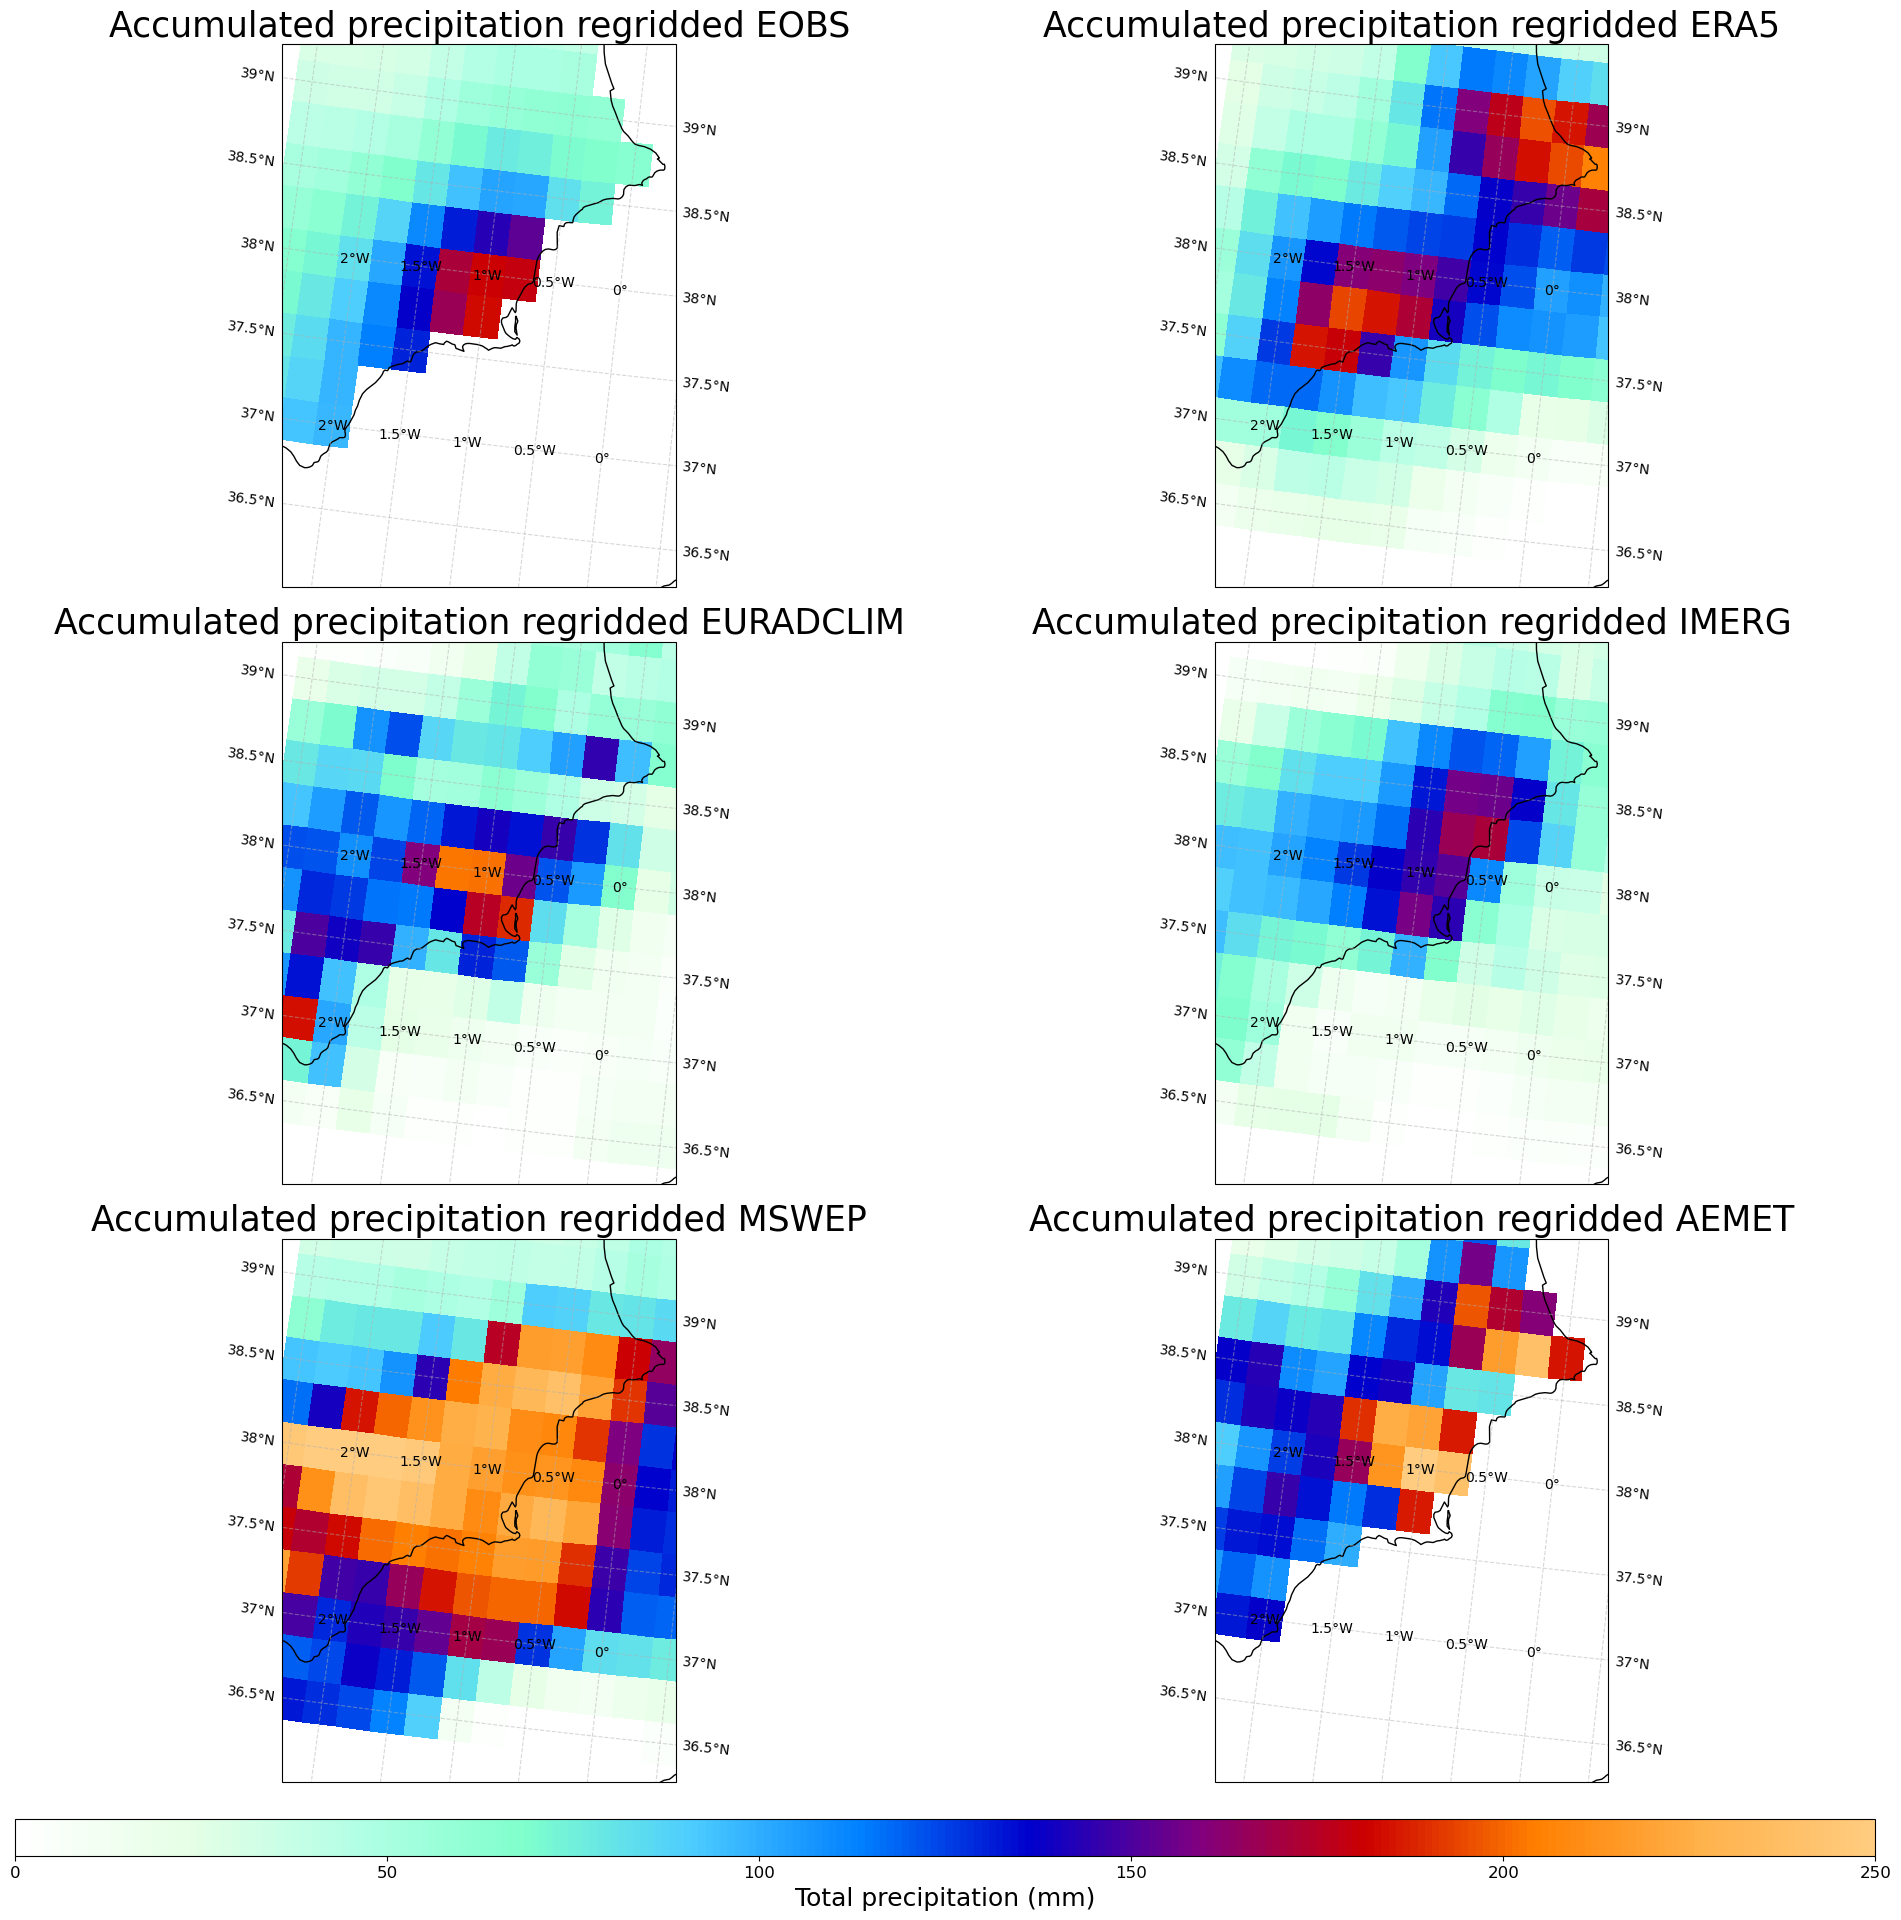

In [16]:
multiple_plots(
    datasets = data,
    name = 'Accumulated precipitation regridded',
    begin_long = begin_long + 0.25,
    end_long = end_long - 0.25,
    begin_lat = begin_lat -0.25,
    end_lat = end_lat -0.25,
    scale_global = False,
    ind_colorbar = False,
    colormap = None,
    label = 'Total precipitation (mm)',
    output = output,
    values = 'precipitation',
    vmax = 250,
    vmin = 0
    
)

In [9]:
A = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EOBS_regrid.csv')
B = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/ERA5_orig.csv')
C = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EURADCLIM_regrid_adjusted.csv')
D = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/IMERG_regrid.csv')
E = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/MSWEP_regrid.csv')
F = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/AEMET_regrid.csv')

Ao = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EOBS_orig.csv')
Bo = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/ERA5_orig.csv')
Co = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EURADCLIM_orig_adjusted.csv')
Do = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/IMERG_orig.csv')
Eo = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/MSWEP_orig.csv')
Fo = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/AEMET_orig_adjusted.csv')

A.name = 'E-OBS'
B.name = 'ERA5'
C.name = 'EURADCLIM'
D.name = 'IMERG'
E.name = 'MSWEP'
F.name = 'AEMET'

Ao.name = 'E-OBS'
Bo.name = 'ERA5'
Co.name = 'EURADCLIM'
Do.name = 'IMERG'
Eo.name = 'MSWEP'
Fo.name = 'AEMET'

data_r = [A,B,C,D,E,F]
data_o = [Ao,Bo,Co,Do,Eo,Fo]



In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.colors as colors
import numpy as np

def multiple_plots_comparison(
    output,
    original_datasets,
    regridded_datasets,
    name,
    begin_long,
    end_long,
    begin_lat,
    end_lat,
    label,
    values,
    scale_global=False,
    colormap=None,
    vmin=None,
    vmax=None,
    vcenter=None
):
    """
    Generates a 3x4 plot comparing original and regridded datasets with refined layout.

    Args:
        output (str): Path to save the output figure.
        original_datasets (list): List of original data DataFrames.
        regridded_datasets (list): List of regridded data DataFrames (same order as original).
        name (str): Base name for the plot title.
        begin_long (float): Western extent of the plot.
        end_long (float): Eastern extent of the plot.
        begin_lat (float): Southern extent of the plot.
        end_lat (float): Northern extent of the plot.
        label (str): Label for the colorbar.
        values (str): Column name containing the values to plot.
        scale_global (bool, optional): Whether to use a global color scale. Defaults to False.
        colormap (matplotlib.colors.Colormap, optional): Custom colormap to use. Defaults to None.
        vmin (float, optional): Minimum value for the color scale. Defaults to None.
        vmax (float, optional): Maximum value for the color scale. Defaults to None.
        vcenter (float, optional): Center value for a diverging color scale. Defaults to None.
    """

    
    # Define the colors and their positions if no colormap is provided
    if colormap is None:
        color = [
            (1.0, 1.0, 1.0),      # White for 0.3 mm
            (0.9, 1.0, 0.9),      # Very light green for 2 mm
            (0.7, 1.0, 0.9),      # Pastel cyan for 5 mm
            (0.5, 1.0, 0.8),      # Pastel green for 10 mm
            (0.3, 0.8, 1.0),      # Pastel blue for 20 mm
            (0.0, 0.5, 1.0),      # Dark blue for 35 mm
            (0.0, 0.0, 0.8),      # Darker blue for 50 mm
            (0.5, 0.0, 0.5),      # Dark red for 70 mm
            (0.8, 0.0, 0.0),      # Dark red for 90 mm
            (1.0, 0.5, 0.0),      # Pastel orange for 120 mm
            (1.0, 0.7, 0.3),      # Lighter pastel orange for 150 mm
            (1.0, 0.8, 0.5),      # Very light pastel orange for 180 mm
        ]
        cmap = LinearSegmentedColormap.from_list("custom_colormap", color)
    else:
        cmap = colormap

    # Set the projection
    projection = ccrs.LambertConformal(central_longitude=10, central_latitude=50)
    extent = [begin_long, end_long, begin_lat, end_lat]

    # Pivot the datasets and prepare titles
    all_data = []
    titles = []
    num_datasets = len(original_datasets)
    for i in range(num_datasets):
        original = original_datasets[i].pivot_table(index="latitude", columns="longitude", values=values)
        regridded = regridded_datasets[i].pivot_table(index="latitude", columns="longitude", values=values)
        all_data.extend([original, regridded])
        titles.append(f"({chr(ord('a') + 2*i)}) {original_datasets[i].name} original")
        titles.append(f"({chr(ord('b') + 2*i)}) {regridded_datasets[i].name} regridded")

    # Determine global scaling if requested
    if scale_global:
        all_values = [df.values.flatten() for df in all_data]
        global_min = np.nanmin(np.concatenate(all_values))
        global_max = np.nanmax(np.concatenate(all_values))
        if vcenter is not None and global_min < vcenter < global_max:
            norm = TwoSlopeNorm(vmin=global_min, vcenter=vcenter, vmax=global_max)
        else:
            norm = colors.Normalize(vmin=global_min, vmax=global_max)
    else:
        norm = None

    # Set up the figure and grid layout (3 rows, 4 columns)
    fig = plt.figure(figsize=(37, 32)) # Adjust figure size for better aspect
    gs = fig.add_gridspec(3, 5, width_ratios=[1, 1, 0.025, 1,1], hspace=0.001) # Adjust wspace and hspace

    axes = []
    for i in range(3):
        for j in range(5):
            # Adjust column spacing for the gap
            if j == 2:
                ax = fig.add_subplot(gs[i, j])
                ax.axis('off')
            else:
                ax = fig.add_subplot(gs[i, j], projection=projection)
            axes.append(ax)

    # Create the plots
    for i, (df, title) in enumerate(zip(all_data, titles)):

        if i == 0 or i == 1:
            ax = axes[i]
        if i == 2 or i == 3 or i == 4 or i == 5:
            ax = axes[i+1]
        if i == 6 or i == 7 or i == 8 or i == 9:
            ax = axes[i+2]
        if i == 10 or i == 11:
            ax = axes[i+3]
        lon, lat = np.meshgrid(df.columns, df.index)

        if norm is not None and scale_global:
            mesh = ax.pcolormesh(lon, lat, df.values, cmap=cmap, transform=ccrs.PlateCarree(), norm=norm)
        elif vmin is not None and vmax is not None:
            if vcenter is not None and vmin < vcenter < vmax:
                current_norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
            else:
                current_norm = colors.Normalize(vmin=vmin, vmax=vmax)
            mesh = ax.pcolormesh(lon, lat, df.values, cmap=cmap, transform=ccrs.PlateCarree(), norm=current_norm)
        else:
            mesh = ax.pcolormesh(lon, lat, df.values, cmap=cmap, transform=ccrs.PlateCarree())

        ax.set_title(' ' + title, loc='left',y = 0.94, fontsize=28,fontweight='extra bold') # Title on top left, larger font
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_extent([begin_long, end_long, begin_lat, end_lat], crs=ccrs.PlateCarree())
        if i%2 == 0:
            gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
        else:
            gl = ax.gridlines(draw_labels=False, linestyle='--', alpha=0.5)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 23}
        gl.ylabel_style = {'size': 23}

    # Add a single colorbar at the bottom
    cbar_ax = fig.add_axes([0.35, 0.05, 0.3, 0.02]) # [left, bottom, width, height]
    cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal', label=label)
    cbar.set_label(label, fontsize=37, labelpad = -160) # Larger label font
    cbar.ax.tick_params(labelsize=35) # Larger tick font

    
    plt.savefig(output + name, dpi=300, bbox_inches='tight')
    plt.savefig(output + name + '.pdf', bbox_inches='tight')
    plt.show()
    

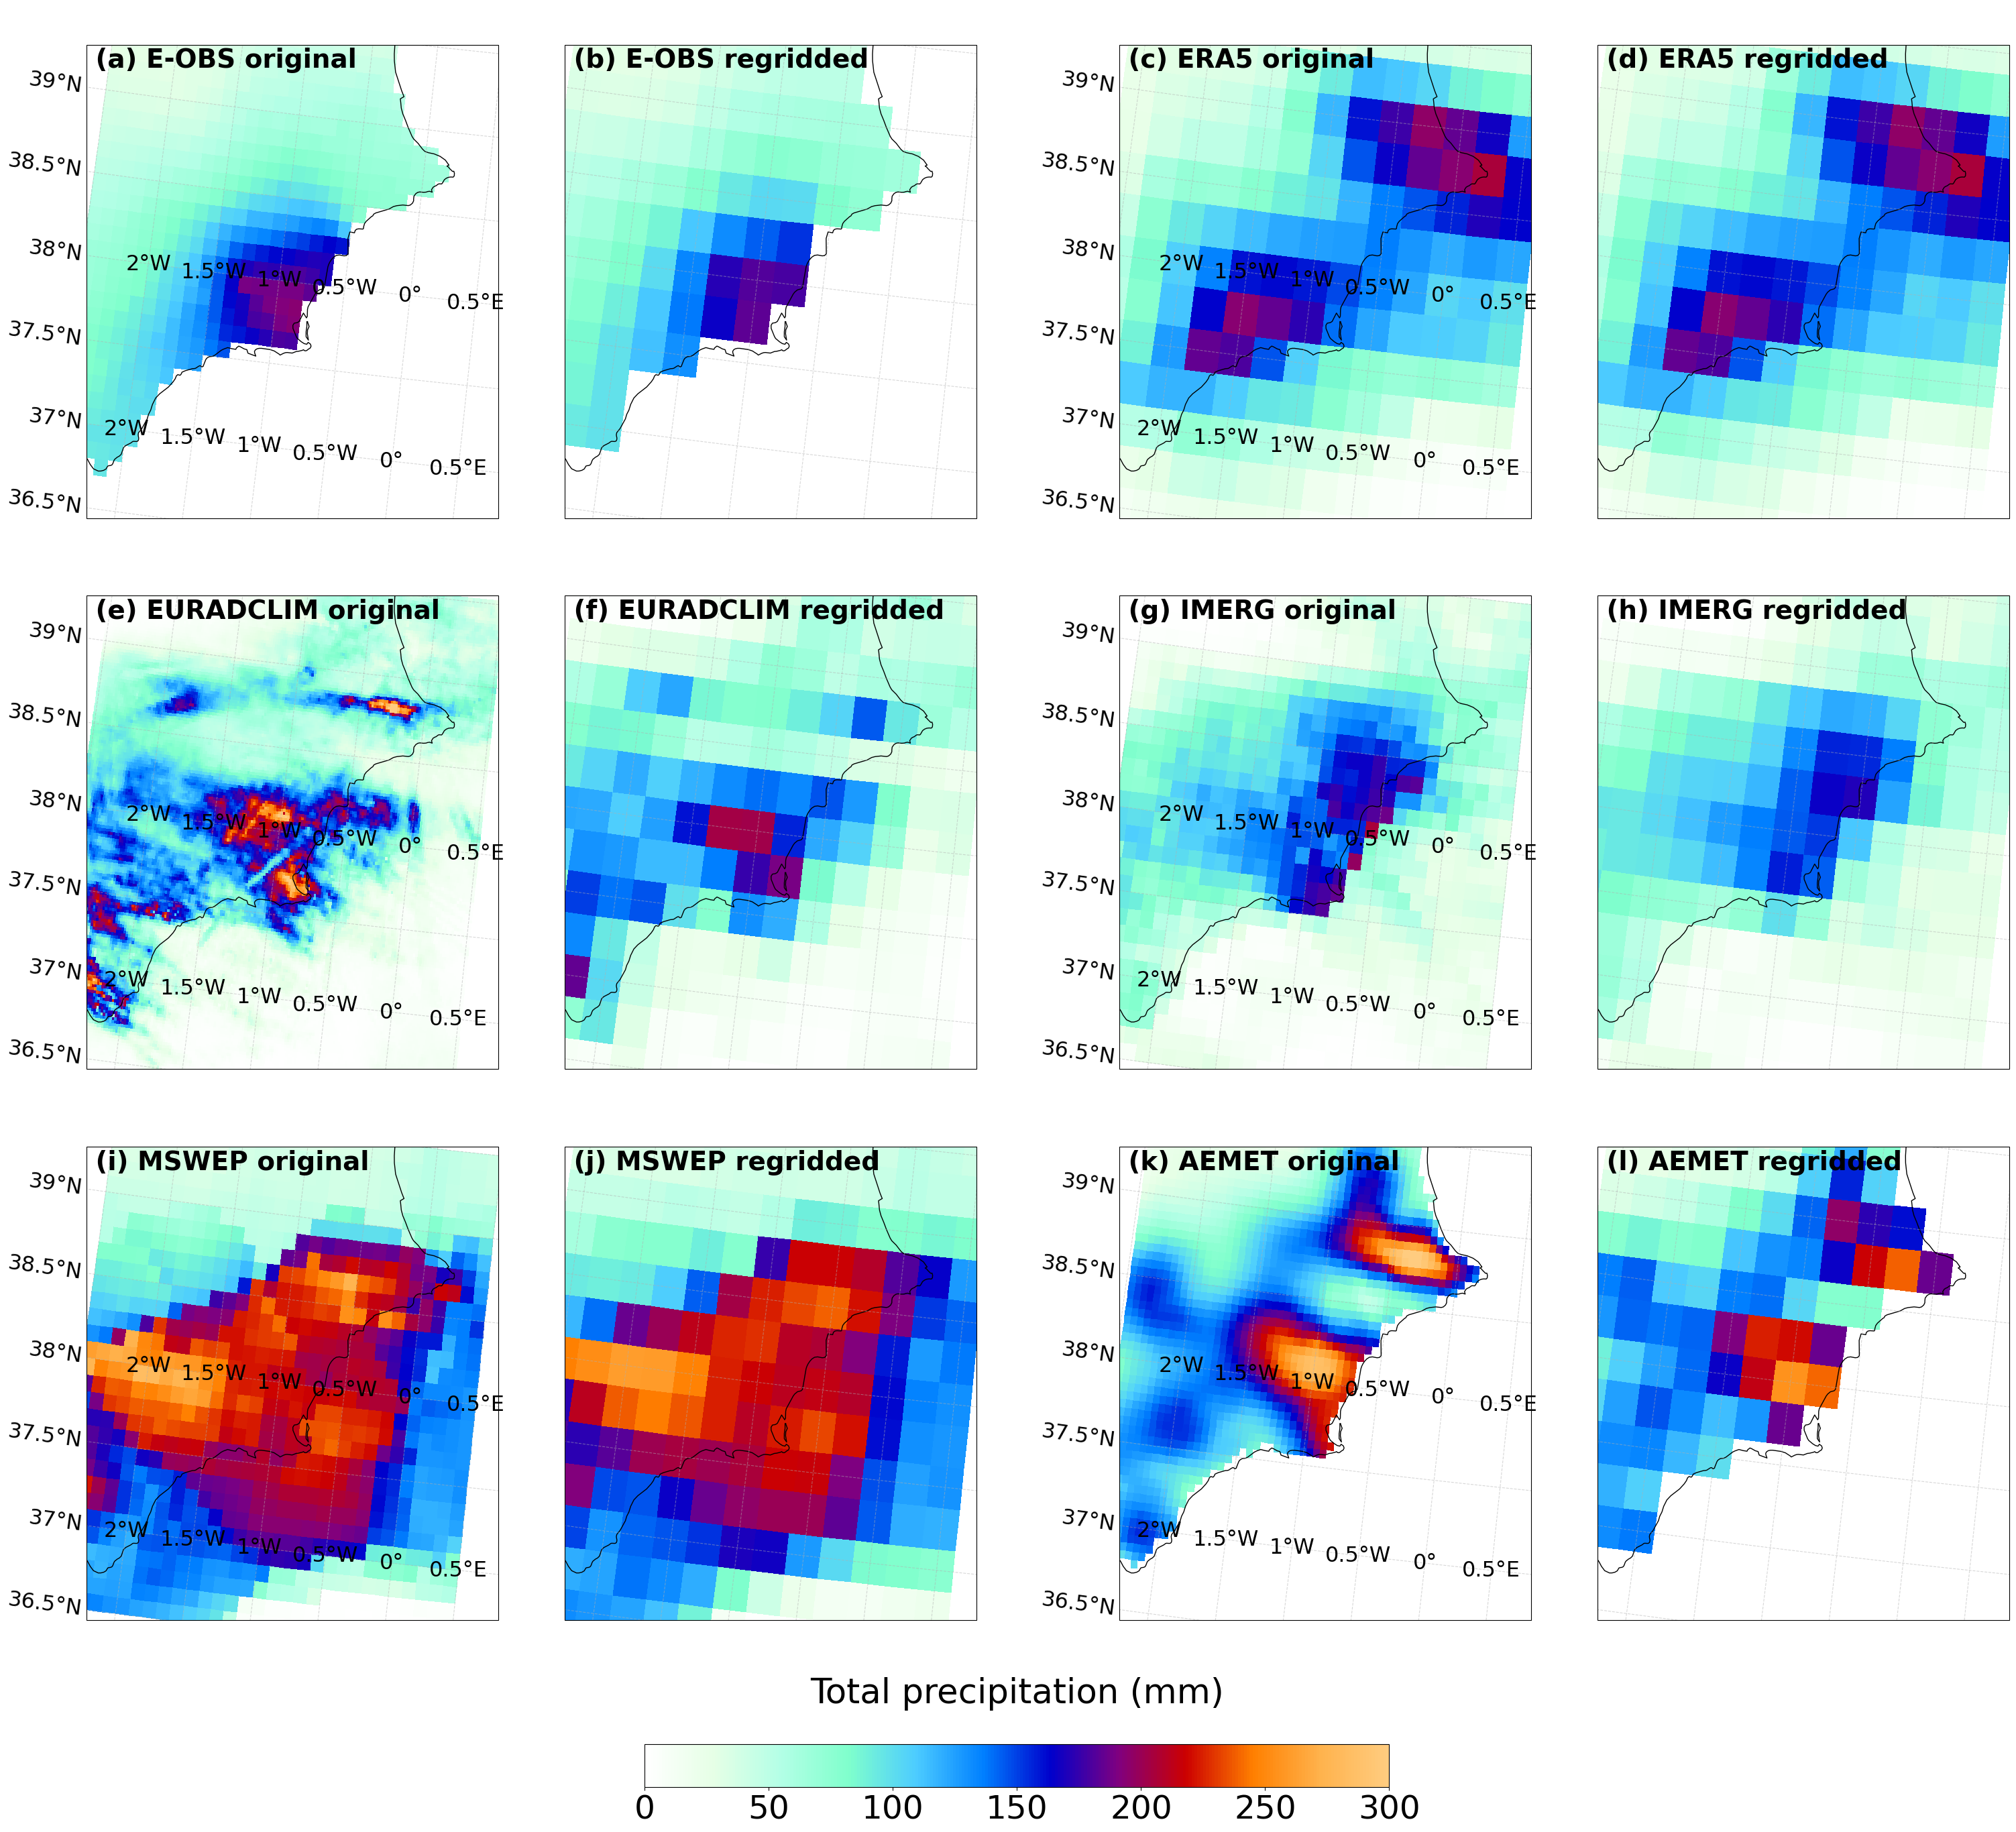

In [11]:

plot_name = "Total_precip"
multiple_plots_comparison(
    output=output,
    original_datasets=data_o,  # Your list of original DataFrames
    regridded_datasets=data_r, # Your list of regridded DataFrames
    name=plot_name,
    begin_long=begin_long + 0.25,
    end_long=end_long,
    begin_lat=begin_lat + 0.2,
    end_lat=end_lat - 0.2,
    label="Total precipitation (mm)",
    values="precipitation",
    scale_global=False, # Or False if you want to specify vmin/vmax
    colormap=None, # Optional custom colormap
    vmin=0,       # Optional
    vmax=300       # Optional   # Optional for diverging colormap
)

## Make pixel to pixel comparaison

In [31]:
from difference import difference2mean

In [6]:
A = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EOBS_regrid.csv')
B = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/ERA5_orig.csv')
C = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EURADCLIM_regrid.csv')
D = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/IMERG_regrid.csv')
E = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/MSWEP_regrid.csv')
F = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/EURADCLIM_regrid_adjusted.csv')
G = pd.read_csv('/home/adelaly/BA_work/output/Cartagena_2019/AEMET_regrid.csv')

In [7]:
A.name = 'E-OBS'
B.name = 'ERA5'
C.name = 'EURADCLIM'
D.name = 'IMERG'
E.name = 'MSWEP'
F.name = 'EURADCLIM'
G.name = 'AEMET'
data = [A,B,F,D,E,G]

In [28]:
A.name = 'EOBS'
B.name = 'ERA5'
C.name = 'EURADCLIM'
D.name = 'IMERG'
E.name = 'MSWEP'
F.name = 'EURADCLIM'
G.name = 'Local'
#data = [A,B,F,D,E,G]

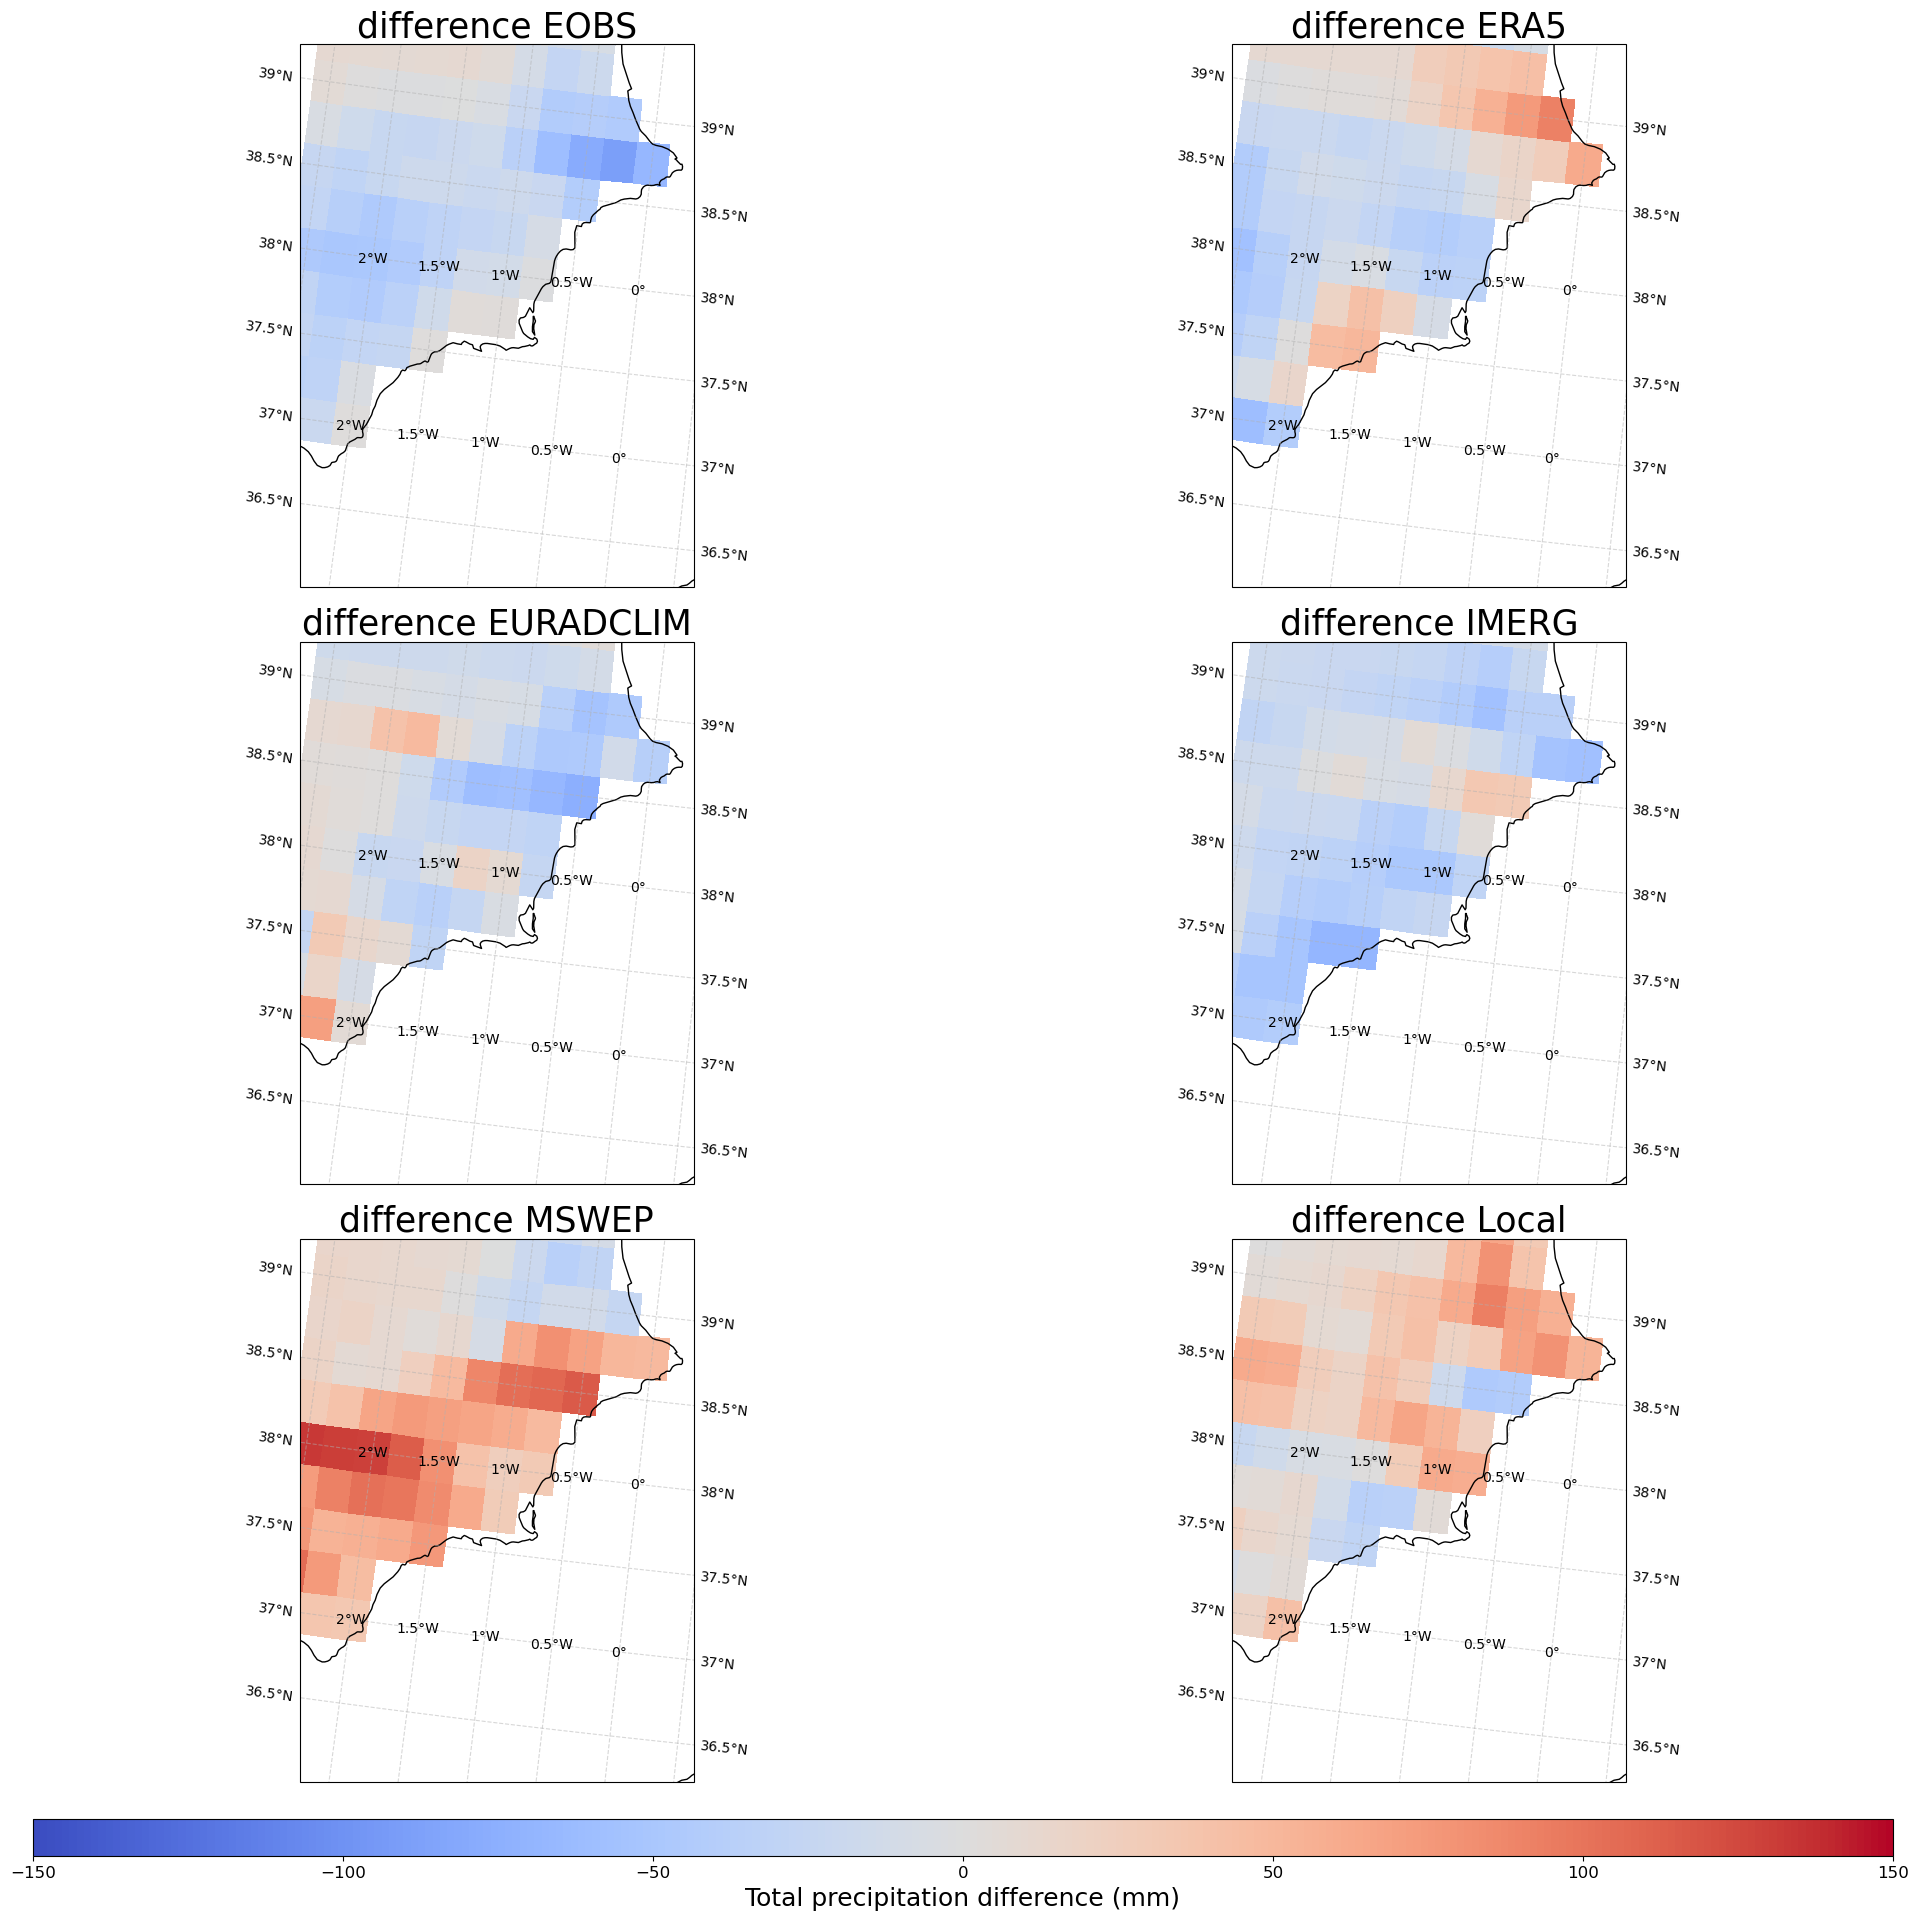

In [34]:
difference2mean(
    datasets = data,
    begin_long = begin_long + 0.25,
    end_long = end_long - 0.25,
    begin_lat = begin_lat -0.25,
    end_lat = end_lat -0.25,
    output = output,
    vmax = 150,
    vmin = -150,
    vcenter = 0,
    event = 'Cartagena_2019',
    save = True,
    plot = True
)
    

### without reference

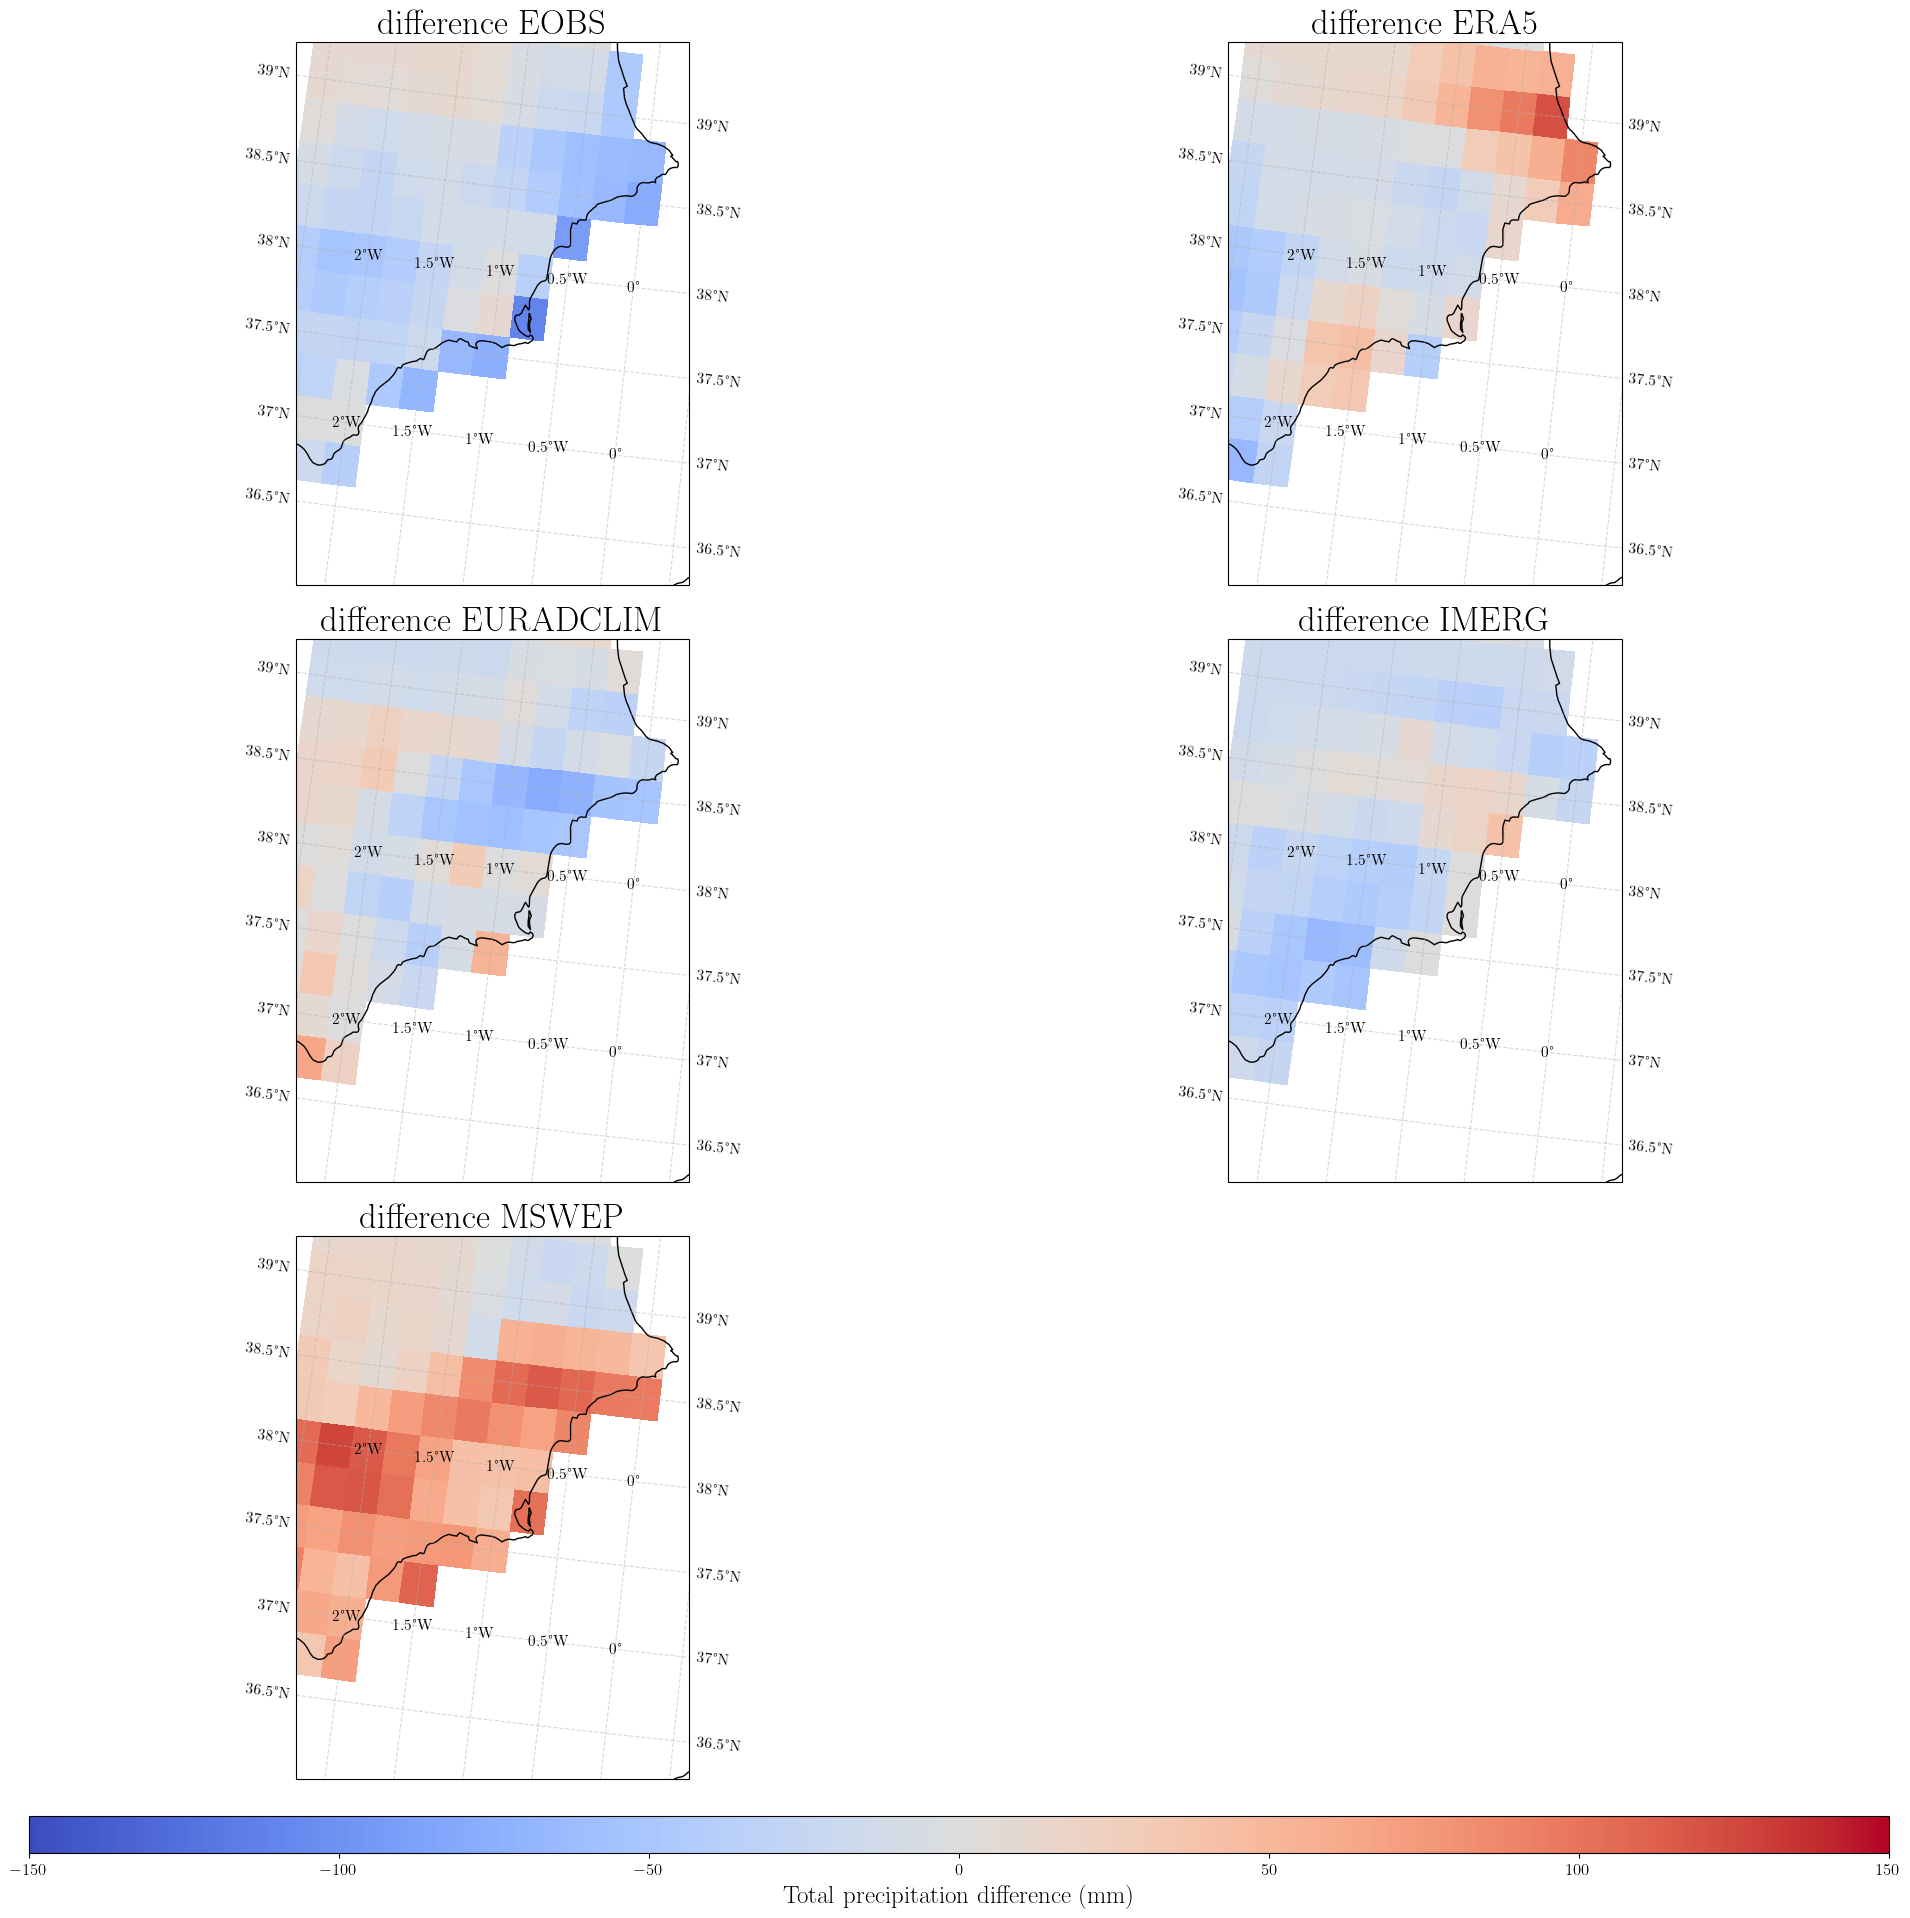

In [8]:
data = [A,B,F,D,E]
difference2mean(
    datasets = data,
    begin_long = begin_long + 0.25,
    end_long = end_long - 0.25,
    begin_lat = begin_lat -0.25,
    end_lat = end_lat -0.25,
    output = output,
    vmax = 150,
    vmin = -150,
    vcenter = 0,
    event = 'Cartagena_2019'
)
    

## Taylor

In [8]:
import skill_metrics as sm
sys.path.append('/home/adelaly/BA_work/Taylor_diagramm')


In [9]:
input_ = '/home/adelaly/BA_work/output/Cartagena_2019/'
ref = '/home/adelaly/BA_work/output/Cartagena_2019/AEMET_regrid.csv'
f_p_A = '/home/adelaly/BA_work/output/Cartagena_2019/EOBS_regrid.csv'
f_p_B = '/home/adelaly/BA_work/output/Cartagena_2019/ERA5_orig.csv'
f_p_C = '/home/adelaly/BA_work/output/Cartagena_2019/EURADCLIM_regrid.csv'
f_p_D = '/home/adelaly/BA_work/output/Cartagena_2019/IMERG_regrid.csv'
f_p_E = '/home/adelaly/BA_work/output/Cartagena_2019/MSWEP_regrid.csv'
f_p_F = '/home/adelaly/BA_work/output/Cartagena_2019/EURADCLIM_regrid_adjusted.csv'
f_p_G = '/home/adelaly/BA_work/output/Cartagena_2019/AEMET_regrid.csv'



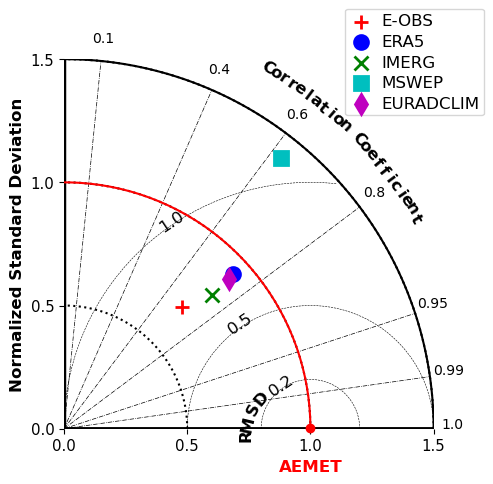

In [10]:
from taylor_diagram import plot_taylor as tay

# Read data from CSV files
data_files = [f_p_A,
              f_p_B,
             f_p_D,
              f_p_E,
              f_p_F,
            ref
         ]
label = [ G.name,A.name, B.name, D.name,E.name, F.name]
tay(
    data_files = data_files,
    label = label,
    name = 'Cartagena_2019',
output = output,
    savefig = True
)

In [26]:
test = pd.read_csv(ref)
mask = test['precipitation'].isna()
for i in data_files:
    i = pd.read_csv(i)
    i[mask] = np.nan
    print(i['precipitation'].corr(test['precipitation']))


0.6956736450518259
0.7356786314323931
0.7408124565161521
0.6249901431108449
0.7399121760672968
1.0
